<a href="https://colab.research.google.com/github/Runshi-Yang/JSC270_HW4_2022_Runshi/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 0: Dataset Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# read data from csv files
train_data = pd.read_csv('https://raw.githubusercontent.com/jsAiyaya/JSC270_Data_Science_1/main/covid-tweets-train.csv', encoding = 'utf-8')
test_data = pd.read_csv('https://raw.githubusercontent.com/jsAiyaya/JSC270_Data_Science_1/main/covid-tweets-test.csv', encoding = 'utf-8')

In [ ]:
# delete the useless column
train_data = train_data.drop(['Unnamed: 0'], axis = 1)
test_data = test_data.drop(['Unnamed: 0'], axis = 1)

In [ ]:
# have a glance of the first few observations of the dataset
train_data.head(5)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,advice Talk to your neighbours family to excha...,2
2,Coronavirus Australia: Woolworths to give elde...,2
3,My food stock is not the only one which is emp...,2
4,"Me, ready to go at supermarket during the #COV...",0


In [ ]:
# notice that the data type of Sentiment in train_data is object
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41155 entries, 0 to 41154
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41155 non-null  object
 1   Sentiment      41153 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [ ]:
# however, the data type of Sentiment in test_data is int
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  3798 non-null   object
 1   Sentiment      3798 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 59.5+ KB


In [ ]:
# first remove observations with Sentiment value other than '0', '1', '2' (in train_data) or 0, 1, 2 (in test_data)
train_data.drop(train_data.index[(train_data['Sentiment'] != '0') & (train_data['Sentiment'] != '1') & (train_data['Sentiment'] != '2')], inplace= True)
test_data.drop(test_data.index[(test_data['Sentiment'] != 0) & (test_data['Sentiment'] != 1) & (test_data['Sentiment'] != 2)], inplace= True)
# then change the data type of Sentiment in train_data to int
train_data['Sentiment'] = train_data['Sentiment'].astype('int')

Now, we've finished processing the data we need in Part 1.

# **Part 1: Sentiment Analysis with a Twitter Dataset**

### **(A)**

In [ ]:
count_table = train_data.groupby('Sentiment').count()
count_table.columns = ["count"]
print(count_table, "\n")

total_num = len(train_data)
prop_table = count_table / total_num
prop_table.columns = ["proportion"]
print(prop_table)

           count
Sentiment       
0          15397
1           7712
2          18042 

           proportion
Sentiment            
0            0.374159
1            0.187407
2            0.438434


### **(B)**

In [ ]:
# Here we write two functions for tokenization.

def tokenize_alternate(df):
  df['tokens'] = df['OriginalTweet'].apply(nltk.word_tokenize)

def tokenize(df):
  tokens = []
  for row in df['OriginalTweet']:
    # delete pattern http
    tokens.append(row.split())
  df['tokens'] = tokens

tokenize(train_data)
tokenize(test_data)

### **(C)**

In [ ]:
# remove tokens beginning with http
def remove_url(df):
  tokens_no_url = []
  for row in df['tokens']:
    # delete pattern http
    tokens_no_url.append([re.sub('http.*', '', t) for t in row])
  df['tokens_no_url'] = tokens_no_url

remove_url(train_data)
remove_url(test_data)

### **(D)**

In [ ]:
def remove_punct(df):
  tokens_no_punct = []
  for row in df['tokens_no_url']:
    tokens_no_punct.append([re.sub('[^\w\s]', '', t) for t in row])
  df['tokens_no_punc'] = tokens_no_punct

remove_punct(train_data)
remove_punct(test_data)

In [ ]:
def lowercase(df):
  lowercase_tokens = []
  for row in df['tokens_no_punc']:
    lowercase_tokens.append([t.lower() for t in row])
  df['tokens_lowercase'] = lowercase_tokens

lowercase(train_data)
lowercase(test_data)
train_data.head()

,OriginalTweet,Sentiment,tokens,tokens_no_url,tokens_no_punc,tokens_lowercase
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[@MeNyrbie, @Phil_Gahan, @Chrisitv, https://t....","[@MeNyrbie, @Phil_Gahan, @Chrisitv, , and, , a...","[MeNyrbie, Phil_Gahan, Chrisitv, , and, , and, ]","[menyrbie, phil_gahan, chrisitv, , and, , and, ]"
1,advice Talk to your neighbours family to excha...,2,"[advice, Talk, to, your, neighbours, family, t...","[advice, Talk, to, your, neighbours, family, t...","[advice, Talk, to, your, neighbours, family, t...","[advice, talk, to, your, neighbours, family, t..."
2,Coronavirus Australia: Woolworths to give elde...,2,"[Coronavirus, Australia:, Woolworths, to, give...","[Coronavirus, Australia:, Woolworths, to, give...","[Coronavirus, Australia, Woolworths, to, give,...","[coronavirus, australia, woolworths, to, give,..."
3,My food stock is not the only one which is emp...,2,"[My, food, stock, is, not, the, only, one, whi...","[My, food, stock, is, not, the, only, one, whi...","[My, food, stock, is, not, the, only, one, whi...","[my, food, stock, is, not, the, only, one, whi..."
4,"Me, ready to go at supermarket during the #COV...",0,"[Me,, ready, to, go, at, supermarket, during, ...","[Me,, ready, to, go, at, supermarket, during, ...","[Me, ready, to, go, at, supermarket, during, t...","[me, ready, to, go, at, supermarket, during, t..."


### **(E)**

In [ ]:
# We use the Porter stemmer
stemmer = PorterStemmer()

def stem(df):
  stemmed_tokens = []
  for row in df['tokens_lowercase']:
    stemmed_tokens.append([stemmer.stem(t) for t in row])
  df['tokens'] = stemmed_tokens

stem(train_data)
stem(test_data)

### **(F)**

In [ ]:
sw = stopwords.words('english')[:100]
def remove_stopwords(df):
  tokens_no_sw = []
  for row in df['tokens']:
    tokens_no_sw.append([w for w in row if w not in sw])
  df['tokens'] = tokens_no_sw

remove_stopwords(train_data)
remove_stopwords(test_data)

### **(G)**

In [ ]:
def remove_empty_string(df):
  tokens_no_empty = []
  for row in df['tokens']:
    tokens_no_empty.append([w for w in row if w != ''])
  df['tokens'] = tokens_no_empty

remove_empty_string(train_data)
remove_empty_string(test_data)

In [ ]:
# Separate labels from features, converting to numpy arrays
X_train, y_train = train_data['tokens'].to_numpy(), train_data['Sentiment'].to_numpy()
X_test, y_test = test_data['tokens'].to_numpy(), test_data['Sentiment'].to_numpy()

X = np.concatenate([X_train, X_test])

In [ ]:
print(f"Total vocabulary length: {np.shape(np.unique(np.concatenate(X)))[0]}")

Total vocabulary length: 55432


In [ ]:
# Since we've already done some steps, we will use a dummy function to override these components.
def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 3500)

count_vec.fit(X)
counts_train = count_vec.transform(X_train)
counts_test = count_vec.transform(X_test)
print("train data:")
print(counts_train.toarray())
print("\n test data:")
print(counts_test.toarray())

train data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 test data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### **(H)**

In [ ]:

# Fit the Naive Bayes model to our training data
nb = MultinomialNB()
# Fit model to training data
nb.fit(counts_train, y_train)
y_train_preds = nb.predict(counts_train)

# Predict on test data
y_test_preds = nb.predict(counts_test)

print(f"Training accuracy: {accuracy_score(y_train, y_train_preds):.4f}")
print(f"Training error:    {1-accuracy_score(y_train, y_train_preds):.4f}")
print(f"Test accuracy:     {accuracy_score(y_test, y_test_preds):.4f}")
print(f"Test error:        {1-accuracy_score(y_test, y_test_preds):.4f}")

Training accuracy: 0.7277
Training error:    0.2723
Test accuracy:     0.6919
Test error:        0.3081


In [ ]:
for label in range(3):
  flag = y_train == label
  tokens_label = X_train[flag]
  words, counts = np.unique(np.concatenate(tokens_label), return_counts=True)
  prob = counts / np.sum(counts)
  top5_idx = prob.argsort()[-5:][::-1]
  print(f"Sentiment {label}: {words[top5_idx]}")
  print(f"Counts {label}:    {counts[top5_idx]}")

Sentiment 0: ['coronaviru' 'covid19' 'price' 'food' 'thi']
Counts 0:    [6703 4862 4332 3622 3206]
Sentiment 1: ['coronaviru' 'covid19' 'store' 'supermarket' 'price']
Counts 1:    [3792 2751 1581 1435 1361]
Sentiment 2: ['coronaviru' 'covid19' 'store' 'thi' 'price']
Counts 2:    [7466 6001 3895 3770 3322]


### **(I)**

### **(J)**

In [ ]:
# Since we've already done some steps, we will use a dummy function to override these components.
def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 3000)

count_vec.fit(X_train)
counts_train = count_vec.transform(X_train)
counts_test = count_vec.transform(X_test)
print("train data:")
print(counts_train.toarray())
print("\n test data:")
print(counts_test.toarray())

train data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 test data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# TF-IDF Vectorize
tfidf = TfidfTransformer()

tfs = tfidf.fit(counts_train)
tfs_X_train = tfidf.transform(counts_train)
tfs_X_test = tfidf.transform(counts_test)

In [ ]:
# Fit model to training data
nb.fit(tfs_X_train, y_train)
tfs_y_train_preds = nb.predict(tfs_X_train)

# Predict on test data
tfs_y_test_preds = nb.predict(tfs_X_test)

print(f"Training accuracy using TF-IDF: {accuracy_score(y_train, tfs_y_train_preds):.4f}")
print(f"Test accuracy using TF-IDF:     {accuracy_score(y_test, tfs_y_test_preds):.4f}")

Training accuracy using TF-IDF: 0.7016
Test accuracy using TF-IDF:     0.6769


### **(K)**

In [ ]:
# Lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(df):
  lemmatized_tokens = []
  for row in df['tokens_lowercase']:
    lemmatized_tokens.append([lemmatizer.lemmatize(t) for t in row])
  df['tokens'] = lemmatized_tokens

lemmatize(train_data)
lemmatize(test_data)

remove_stopwords(train_data)
remove_stopwords(test_data)

remove_empty_string(train_data)
remove_empty_string(test_data)

In [ ]:
X_train, y_train = train_data['tokens'].to_numpy(), train_data['Sentiment'].to_numpy()
X_test, y_test = test_data['tokens'].to_numpy(), test_data['Sentiment'].to_numpy()

X = np.concatenate([X_train, X_test])

# Since we've already done some steps, we will use a dummy function to override these components.
def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    max_features = 5000)

count_vec.fit(X_train)
counts_train = count_vec.transform(X_train)
counts_test = count_vec.transform(X_test)
print("train data:")
print(counts_train.toarray())
print("\n test data:")
print(counts_test.toarray())

train data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 test data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# TF-IDF Vectorize
tfidf = TfidfTransformer()

tfs = tfidf.fit(counts_train)
tfs_X_train = tfidf.transform(counts_train)
tfs_X_test = tfidf.transform(counts_test)

# Fit model to training data
nb.fit(tfs_X_train, y_train)
tfs_y_train_preds = nb.predict(tfs_X_train)

# Predict on test data
tfs_y_test_preds = nb.predict(tfs_X_test)

print(f"Training accuracy using TF-IDF: {accuracy_score(y_train, tfs_y_train_preds):.4f}")
print(f"Test accuracy using TF-IDF:     {accuracy_score(y_test, tfs_y_test_preds):.4f}")

Training accuracy using TF-IDF: 0.7193
Test accuracy using TF-IDF:     0.6759


# **Part 2: Having fun with NLP using the Twitter API**

In [ ]:
api_key = 'AAZEoAavwrLaz4ANIwmzaAuZJ'

api_secret_key = 'CHfzgbCAcGn7SwD1YQu8LFhdOFO9jUxoYTpZ8KSNLglu9dKbOI'

access_key =  '1498783321463136257-4gOSZBPQwgHbzQblbjOUsz22iRay40'

access_secret = 'AvkzUflIzQYeZrpvPcD7Vt4VJmv0xKQfFuup7NwQEP5II'

In [ ]:
import tweepy as tw

# Use credentials to authorize access
auth = tw.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
# This code block would run for a long time. We have saved the result in a csv
# file below if you don't want to run it.

# search_words = 'oil'
# date_since = "2022-03-10"
# search_with_filter = search_words + " -filter:retweets"

# #Collect tweets (here, I get 10000)
# tweets = tw.Cursor(api.search,
#               q=search_with_filter,
#               lang="en",
#               tweet_mode="extended",
#               since=date_since).items(10000)

In [ ]:
# OriginalTweet = []
# for tweet in tweets:
#   OriginalTweet.append(tweet.full_text)

# a = {'OriginalTweet': OriginalTweet}
# df = pd.DataFrame(data = a)
# df.head()

In [ ]:
# from google.colab import files
# df.to_csv('a4.csv')
# files.download('a4.csv')

In [ ]:
url = 'https://raw.githubusercontent.com/jsAiyaya/JSC270_Data_Science_1/main/tweet_oil_data.csv'
df = pd.read_csv(url)
df = df.drop(['Unnamed: 0'], axis = 1)

In [ ]:
# tokenization
tokenize_alternate(df)

In [ ]:
!pip install matplotlib

Text(0, 0.5, 'Count')

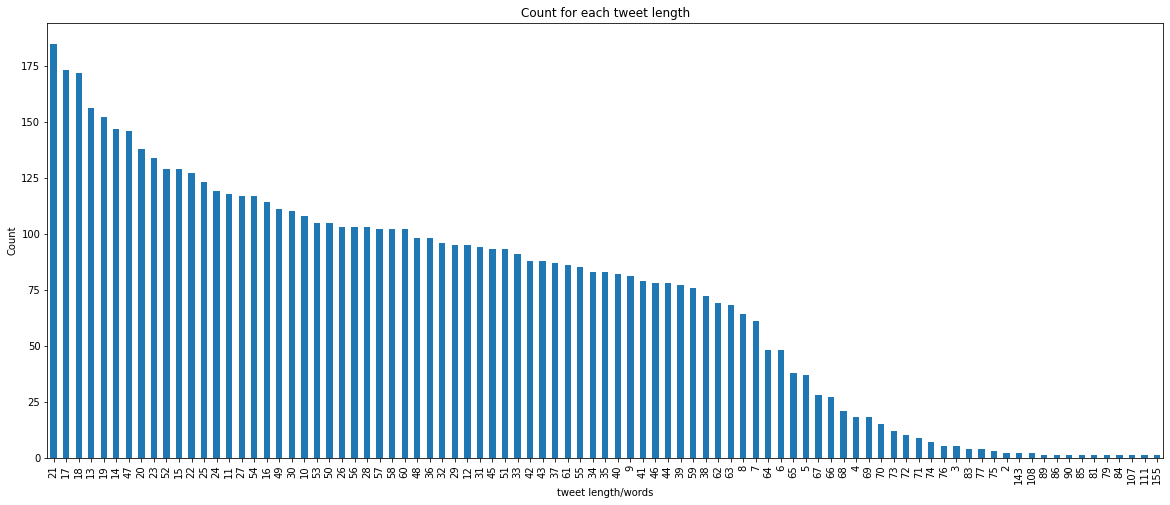

In [ ]:
lens = []
for row in df['tokens']:
  lens.append(len(row))
df['lens'] = lens

ax = df['lens'].value_counts().plot(kind='bar',
                                    figsize=(20,8),
                                    title="Count for each tweet length")
ax.set_xlabel("tweet length/words")
ax.set_ylabel("Count")


In [ ]:
# remove url
remove_url(df)

# remove punctuation
remove_punct(df)

# convert to lower case
lowercase(df)

# stem
lemmatize(df)

# we use all stopwords here
sw_more = stopwords.words('english')
sw_more.append("s")
def remove_more_stopwords(df):
  tokens_no_sw = []
  for row in df['tokens']:
    tokens_no_sw.append([w for w in row if w not in sw])
  df['tokens'] = tokens_no_sw

# remove stop words
remove_stopwords(df)

# remove empty string
remove_empty_string(df)

df.tail()

,OriginalTweet,tokens,tokens_no_url,tokens_no_punc,tokens_lowercase,lens
6356,@ComfortablySmug Cruz's Self-Serving Campaign ...,"[comfortablysmug, cruz, s, selfserving, campai...","[@, ComfortablySmug, Cruz, 's, Self-Serving, C...","[, ComfortablySmug, Cruz, s, SelfServing, Camp...","[, comfortablysmug, cruz, s, selfserving, camp...",64
6357,Natural-gas futures jump by nearly 6%; oil set...,"[naturalgas, future, jump, nearly, 6, oil, set...","[Natural-gas, futures, jump, by, nearly, 6, %,...","[Naturalgas, futures, jump, by, nearly, 6, , ,...","[naturalgas, futures, jump, by, nearly, 6, , ,...",14
6358,"@ChifeDr Sir, Africa is poor because the leade...","[chifedr, sir, africa, poor, leader, irrespons...","[@, ChifeDr, Sir, ,, Africa, is, poor, because...","[, ChifeDr, Sir, , Africa, is, poor, because, ...","[, chifedr, sir, , africa, is, poor, because, ...",69
6359,Our oil supplements start at £39.95 for 600mg....,"[oil, supplement, start, 3995, 600mg, make, u,...","[Our, oil, supplements, start, at, £39.95, for...","[Our, oil, supplements, start, at, 3995, for, ...","[our, oil, supplements, start, at, 3995, for, ...",41
6360,The Keystone XL Pipeline could be supplying us...,"[keystone, xl, pipeline, could, supplying, u, ...","[The, Keystone, XL, Pipeline, could, be, suppl...","[The, Keystone, XL, Pipeline, could, be, suppl...","[the, keystone, xl, pipeline, could, be, suppl...",50


In [ ]:
len(list(np.unique(np.concatenate(df['tokens']))))

22266

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

X_train = df['tokens'].to_numpy()
def override_fcn(doc):
  return doc

# We will tune the number of topic later
def build_lda(x_train, num_of_topic=8):
  transformed_x_train = count_vec.fit_transform(x_train)
  feature_names = count_vec.get_feature_names()
  lda = LatentDirichletAllocation(n_components=num_of_topic, max_iter=8, learning_method='batch', random_state=0)
  lda_transformed = lda.fit_transform(transformed_x_train)
  return lda, feature_names, lda_transformed

# display the top 30 most probable words for each topic
def display_word_distribution(model, feature_names, n_word):
  for topic_idx, topic in enumerate(model.components_):
    print("Topic %d:" % (topic_idx + 1))
    words = []
    for i in topic.argsort()[:-n_word - 1:-1]:
      words.append(feature_names[i])
    print(words)

lda_model, feature_names, lda_transformed = build_lda(X_train)
display_word_distribution(
    model=lda_model, feature_names=feature_names, 
    n_word=30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 1:
['oil', 'nt', 'not', 'russian', 'gas', 'so', 'u', 'can', 'why', 'need', 'will', 'russia', 'get', 'all', 'war', 'painting', 'buying', 's', 'doe', 'world', 'would', 'how', 'more', 'know', 'country', 'just', 'most', 'new', 'want', 'make']
Topic 2:
['oil', 's', 'gas', 'will', 'now', 'stop', 'stock', 'last', 'woman', 'week', 'food', 'child', 'russian', 'war', 'amp', 'all', 'russia', 'not', 'putin', 'treat', 'coal', 'distributed', 'braun4indiana', 'repbrianfitz', 'wfp', 'cereal', 'exhausted', 'fortified', 'malnourished', 'reprickallen']
Topic 3:
['oil', 'price', 'gas', 'biden', 'u', 's', 'amp', 't', 'ha', 'pipeline', 'energy', 'company', 'wa', 'not', 'production', 'more', 'now', 'will', 'nt', 'trump', 'market', 'keystone', 'when', 'would', 'so', 'supply', 'fuel', 'high', 'policy', 'country']
Topic 4:
['oil', 's', 'not', 'wa', 'all', 'just', 'no', 'like', 'so', 'm', 'nt', 'time', 'get', 'when', 'more', 't', 'good', 'change', 'there', 'well', 'can', 'make', 'car', 'will', 'got', 've',

In [ ]:
topic = []
for n in range (lda_transformed.shape[0]):
  #argmax() gives maximum index value
  topic_doc = lda_transformed[n].argmax()
  # document is n+1
  topic.append(topic_doc + 1)

df["topic"] = topic
df.head()

,OriginalTweet,tokens,tokens_no_url,tokens_no_punc,tokens_lowercase,lens,topic
0,Twenty more #people have been #arrested follow...,"[twenty, more, people, arrested, following, pr...","[Twenty, more, #, people, have, been, #, arres...","[Twenty, more, , people, have, been, , arreste...","[twenty, more, , people, have, been, , arreste...",42,4
1,@Quivcy 1ltr of oil for a pot of stew.\nShe wa...,"[quivcy, 1ltr, oil, pot, stew, wan, swim, inside]","[@, Quivcy, 1ltr, of, oil, for, a, pot, of, st...","[, Quivcy, 1ltr, of, oil, for, a, pot, of, ste...","[, quivcy, 1ltr, of, oil, for, a, pot, of, ste...",16,8
2,@City_Xtra @ManCity @PepTeam YOU HAVE NO FANS ...,"[city_xtra, mancity, pepteam, no, fan, oil, cl...","[@, City_Xtra, @, ManCity, @, PepTeam, YOU, HA...","[, City_Xtra, , ManCity, , PepTeam, YOU, HAVE,...","[, city_xtra, , mancity, , pepteam, you, have,...",15,7
3,@waziu @ikeoluwaaaaaa Exactly. Basically if sh...,"[waziu, ikeoluwaaaaaa, exactly, basically, coo...","[@, waziu, @, ikeoluwaaaaaa, Exactly, ., Basic...","[, waziu, , ikeoluwaaaaaa, Exactly, , Basicall...","[, waziu, , ikeoluwaaaaaa, exactly, , basicall...",63,8
4,"Fair enough, probably just oil or something if...","[fair, enough, probably, just, oil, something,...","[Fair, enough, ,, probably, just, oil, or, som...","[Fair, enough, , probably, just, oil, or, some...","[fair, enough, , probably, just, oil, or, some...",22,4


In [ ]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 5.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=5442fcfbc1d8cb13257257f65de82e1bb77c2d0639c06bb04404ef80cb358327
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
# visualization
import pyLDAvis.sklearn
pic = pyLDAvis.sklearn.prepare(lda_model, count_vec.fit_transform(X_train), count_vec)
pyLDAvis.save_html(pic, 'lda_pass'+str(10)+'.html')
pyLDAvis.display(pic)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

<Figure size 2160x1440 with 0 Axes>

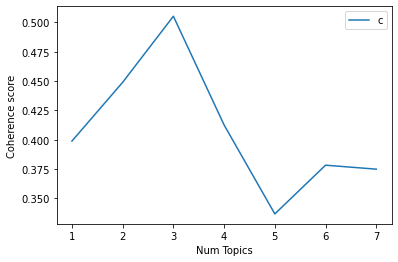

<Figure size 2160x1440 with 0 Axes>

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

id2word = corpora.Dictionary(df['tokens'])
df = df.dropna(subset=['tokens'])
corpus = [id2word.doc2bow(text) for text in df['tokens']]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df["tokens"], start=1, limit=8, step=1)

limit=8; start=1; step=1;
x = range(start, limit, step)
fig, ax = plt.subplots()
ax.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.figure(figsize=(30, 20))